# Setup

In [96]:
from pathlib import Path

import confuse
import pandas

from dialogueactclassification import Classifier

cfg = confuse.LazyConfig('ccc4prc', __name__)
# Add overrides on top of config.yaml for the workspace.
cfg.set_file('./config.workspace.yaml')

dataset_dir = Path(cfg['machine_learning']['labeled_seed_excel_file'].as_filename()).parent
training_dataset_file = dataset_dir / ('training_dataset.csv')
test_dataset_file = dataset_dir / ('test_dataset.csv')

training_dataset = pandas.read_csv(training_dataset_file)
test_dataset = pandas.read_csv(test_dataset_file)

In [97]:
from array import array
from pathlib import Path

import numpy
import pandas
from matplotlib import pyplot
from pandas import DataFrame
from sklearn import metrics

FEATURES = ['body', 'dialogue_act_classification_ml', 'comment_is_by_author']
LABEL = 'code_comprehension_related'
report_dict_list = []

# Original Classifier Model Performance

In [98]:
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

one_hot_encoder_categories = [
    [
        'Accept',
        'Bye',
        'Clarify',
        'Continuer',
        'Emotion',
        'Emphasis',
        'Greet',
        'Other',
        'Reject',
        'Statement',
        'System',
        'whQuestion',
        'yAnswer',
        'nAnswer',
        'ynQuestion'
    ],
    [
        False,  # 0 should come before 1 for numerical columns.
        True
    ]
]

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_pipeline', CountVectorizer(stop_words='english'), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_pipeline': 1.0,
        'categorical_transformer': 1.0,
    },
    verbose=False)

clf_original = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', probability=True))],
    verbose=False)

X_train = training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = training_dataset[LABEL]
y_true = test_dataset[LABEL]

clf_original.fit(X_train, y_train)
y_pred = clf_original.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'Original (CountVectorizer)': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.82781457 0.91240876 0.86805556       137
         Yes  0.53846154 0.35000000 0.42424242        40

    accuracy                      0.78531073       177
   macro avg  0.68313805 0.63120438 0.64614899       177
weighted avg  0.76242405 0.78531073 0.76775880       177



# Evenly distribute the training data labelled as "No" and "Yes".

In [99]:
min_label_count = y_train.value_counts().min()
labelled_yes = training_dataset.loc[training_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = training_dataset.loc[training_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_training_dataset = pandas.concat([labelled_yes, labelled_no])

# Shuffle the order, in order to properly train the model.
evenly_distrubted_training_dataset = evenly_distrubted_training_dataset.sample(frac=1)

# Show the datasets value counts
print(f'Training DataSet - Label "Yes": {len(training_dataset.loc[training_dataset[LABEL] == "Yes"])} v.s. "No": {len(training_dataset.loc[training_dataset[LABEL] == "No"])}, ratio: {len(training_dataset.loc[training_dataset[LABEL] == "Yes"])/len(training_dataset.loc[training_dataset[LABEL] == "No"])}')
print(f'Test Dataset - Label "Yes": {len(test_dataset.loc[test_dataset[LABEL] == "Yes"])} v.s. "No": {len(test_dataset.loc[test_dataset[LABEL] == "No"])}, ratio: {len(test_dataset.loc[test_dataset[LABEL] == "Yes"])/len(test_dataset.loc[test_dataset[LABEL] == "No"])}')
print(f'Training DataSet (evenly distributed) - Label "Yes": {len(evenly_distrubted_training_dataset.loc[evenly_distrubted_training_dataset[LABEL] == "Yes"])} v.s. "No": {len(evenly_distrubted_training_dataset.loc[evenly_distrubted_training_dataset[LABEL] == "No"])}')

Training DataSet - Label "Yes": 67 v.s. "No": 271, ratio: 0.24723247232472326
Test Dataset - Label "Yes": 40 v.s. "No": 137, ratio: 0.291970802919708
Training DataSet (evenly distributed) - Label "Yes": 67 v.s. "No": 67


In [100]:
# Performance after evenly distributed only the training dataset with labels "No" and "Yes".
X_train_evenly_distributed = evenly_distrubted_training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train_evenly_distributed = evenly_distrubted_training_dataset[LABEL]
y_true = test_dataset[LABEL]

clf_original.fit(X_train_evenly_distributed, y_train_evenly_distributed)
y_pred = clf_original.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'Original (CountVectorizer + Evenly Distributed)': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.92682927 0.55474453 0.69406393       137
         Yes  0.35789474 0.85000000 0.50370370        40

    accuracy                      0.62146893       177
   macro avg  0.64236200 0.70237226 0.59888382       177
weighted avg  0.79825649 0.62146893 0.65104467       177



In [101]:
%%script false --no-raise-error
# Performance after evenly distributed both the training and test datasets with labels "No" and "Yes".
# But in practice, the incoming data is likely to be skewed to "No", so this is experiment only.
# Evenly distribute the test data labelled as "No" and "Yes".
min_label_count = y_true.value_counts().min()
labelled_yes = test_dataset.loc[test_dataset[LABEL] == 'Yes'].head(min_label_count)
labelled_no = test_dataset.loc[test_dataset[LABEL] == 'No'].head(min_label_count)
evenly_distrubted_test_dataset = pandas.concat([labelled_yes, labelled_no])

X_train = evenly_distrubted_training_dataset[FEATURES]
X_test = evenly_distrubted_test_dataset[FEATURES]
y_train = evenly_distrubted_training_dataset[LABEL]
y_true = evenly_distrubted_test_dataset[LABEL]

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)

# Tuning - using a different vectorization - TDIDF

In [102]:
# Setup
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC

one_hot_encoder_categories = [
    [
        'Accept',
        'Bye',
        'Clarify',
        'Continuer',
        'Emotion',
        'Emphasis',
        'Greet',
        'Other',
        'Reject',
        'Statement',
        'System',
        'whQuestion',
        'yAnswer',
        'nAnswer',
        'ynQuestion'
    ],
    [
        False,  # 0 should come before 1 for numerical columns.
        True
    ]
]

X_train = evenly_distrubted_training_dataset[FEATURES]
X_test = test_dataset[FEATURES]
y_train = evenly_distrubted_training_dataset[LABEL]
y_true = test_dataset[LABEL]

In [103]:
column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
        # ('author_transformer', OneHotEncoder(categories=[[False, True]]), ['comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
        # 'author_transformer': 0,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'TDIDF': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.96511628 0.60583942 0.74439462       137
         Yes  0.40659341 0.92500000 0.56488550        40

    accuracy                      0.67796610       177
   macro avg  0.68585484 0.76541971 0.65464006       177
weighted avg  0.83889642 0.67796610 0.70382759       177



# Tuning - add Stemming

In [104]:
from nltk.stem.snowball import SnowballStemmer

class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        stemmer = SnowballStemmer('english', ignore_stopwords=True)
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', StemmedCountVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'TDIDF+Stemming': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.96511628 0.60583942 0.74439462       137
         Yes  0.40659341 0.92500000 0.56488550        40

    accuracy                      0.67796610       177
   macro avg  0.68585484 0.76541971 0.65464006       177
weighted avg  0.83889642 0.67796610 0.70382759       177



# Tuning - try adding Lemmatization

In [105]:
from nlp import LemmaTokenizer

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=None, ngram_range=(1, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

clf_svc = full_pipeline

clf_svc.fit(X_train, y_train)
y_pred = clf_svc.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'TDIDF+Lemmatization': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.96039604 0.70802920 0.81512605       137
         Yes  0.47368421 0.90000000 0.62068966        40

    accuracy                      0.75141243       177
   macro avg  0.71704013 0.80401460 0.71790785       177
weighted avg  0.85040467 0.75141243 0.77118562       177



# Tuning - try using MultinominalNB

In [106]:
from sklearn.naive_bayes import MultinomialNB

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', MultinomialNB(fit_prior=True))],
    verbose=False)

clf_multinominal_nb = full_pipeline

clf_multinominal_nb.fit(X_train, y_train)
y_pred = clf_multinominal_nb.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'MultinomialNB': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.91489362 0.62773723 0.74458874       137
         Yes  0.38554217 0.80000000 0.52032520        40

    accuracy                      0.66666667       177
   macro avg  0.65021789 0.71386861 0.63245697       177
weighted avg  0.79526617 0.66666667 0.69390772       177



# Tuning - try using Logistic Regression

In [107]:
from sklearn.linear_model import LogisticRegression

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', LogisticRegression())],
    verbose=False)

clf_logistic_regression = full_pipeline

clf_logistic_regression.fit(X_train, y_train)
y_pred = clf_logistic_regression.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'LogisticRegression': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.96428571 0.59124088 0.73303167       137
         Yes  0.39784946 0.92500000 0.55639098        40

    accuracy                      0.66666667       177
   macro avg  0.68106759 0.75812044 0.64471133       177
weighted avg  0.83627752 0.66666667 0.69311287       177



# Tuning - try using Decision Tree

In [108]:
from sklearn.tree import DecisionTreeClassifier

column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(2, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 3,
        'categorical_transformer': 1,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', DecisionTreeClassifier())],
    verbose=False)

classifier = full_pipeline

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'DecisionTree': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.86868687 0.62773723 0.72881356       137
         Yes  0.34615385 0.67500000 0.45762712        40

    accuracy                      0.63841808       177
   macro avg  0.60742036 0.65136861 0.59322034       177
weighted avg  0.75060031 0.63841808 0.66752849       177



# Tuning the model with Grid Search

In [109]:
column_transformer = ColumnTransformer(
    transformers=[
        ('body_bow_vectorizer', TfidfVectorizer(tokenizer=LemmaTokenizer(), stop_words=None, ngram_range=(1, 2)), 'body'),
        ('categorical_transformer', OneHotEncoder(categories=one_hot_encoder_categories),
            ['dialogue_act_classification_ml', 'comment_is_by_author']),
    ],
    transformer_weights={
        'body_bow_vectorizer': 1,
        'categorical_transformer': 3,
    },
    verbose=False)

full_pipeline = Pipeline(
    steps=[
        ('preprocessor', column_transformer),
        ('classifier', SVC(kernel='linear', C=1.2, probability=True))],
    verbose=False)

scorer = metrics.make_scorer(metrics.precision_score, pos_label="Yes")

grid_search_cv_params = [
    {
        'preprocessor__transformer_weights': [
            {'body_bow_vectorizer': 1, 'categorical_transformer': 1},
            {'body_bow_vectorizer': 1, 'categorical_transformer': 4},
            {'body_bow_vectorizer': 1, 'categorical_transformer': 6},
            {'body_bow_vectorizer': 1, 'categorical_transformer': 10},
            {'body_bow_vectorizer': 2, 'categorical_transformer': 1},
            {'body_bow_vectorizer': 4, 'categorical_transformer': 1},
            {'body_bow_vectorizer': 6, 'categorical_transformer': 1},
            {'body_bow_vectorizer': 10, 'categorical_transformer': 1},                                      
        ]
    },
    {'preprocessor__body_bow_vectorizer__stop_words': [None, 'english']},
    {'preprocessor__body_bow_vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 5), (2, 2), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5)]},
    {'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
    {'classifier__C': [0.8, 1, 1.2, 2, 4]},    
]
clf_grid_search_cv = GridSearchCV(full_pipeline, param_grid=grid_search_cv_params, cv=5, scoring='accuracy')

clf_grid_search_cv.fit(X_train, y_train)
clf_grid_search_cv.best_params_

{'preprocessor__transformer_weights': {'body_bow_vectorizer': 10,
  'categorical_transformer': 1}}

In [110]:
y_pred = clf_grid_search_cv.predict(X_test)

report = metrics.classification_report(y_true, y_pred, digits=8)
print(report)
report_dict_list.append({'TDIDF+GridSearch': metrics.classification_report(y_true, y_pred, output_dict=True)})

precision    recall  f1-score   support

          No  0.92631579 0.64233577 0.75862069       137
         Yes  0.40243902 0.82500000 0.54098361        40

    accuracy                      0.68361582       177
   macro avg  0.66437741 0.73366788 0.64980215       177
weighted avg  0.80792556 0.68361582 0.70943717       177



# Performance Result Comparison

In [111]:
from matplotlib import pyplot

x = [next(iter(report.keys())) for report in report_dict_list]

df = DataFrame({
    'Algorithms': x,
    'no_precision': [next(iter(report.values()))['No']['precision'] for report in report_dict_list],
    'no_recall': [next(iter(report.values()))['No']['recall'] for report in report_dict_list],
    'no_f1_score': [next(iter(report.values()))['No']['f1-score'] for report in report_dict_list],
    'yes_precision': [next(iter(report.values()))['Yes']['precision'] for report in report_dict_list],
    'yes_recall': [next(iter(report.values()))['Yes']['recall'] for report in report_dict_list],
    'yes_f1_score': [next(iter(report.values()))['Yes']['f1-score'] for report in report_dict_list],
    'Accuracy': [next(iter(report.values()))['accuracy'] for report in report_dict_list]})

df

,Algorithms,no_precision,no_recall,no_f1_score,yes_precision,yes_recall,yes_f1_score,Accuracy
0,Original (CountVectorizer),0.827815,0.912409,0.868056,0.538462,0.350,0.424242,0.785311
1,Original (CountVectorizer + Evenly Distributed),0.926829,0.554745,0.694064,0.357895,0.850,0.503704,0.621469
2,TDIDF,0.965116,0.605839,0.744395,0.406593,0.925,0.564885,0.677966
3,TDIDF+Stemming,0.965116,0.605839,0.744395,0.406593,0.925,0.564885,0.677966
4,TDIDF+Lemmatization,0.960396,0.708029,0.815126,0.473684,0.900,0.620690,0.751412
5,MultinomialNB,0.914894,0.627737,0.744589,0.385542,0.800,0.520325,0.666667
6,LogisticRegression,0.964286,0.591241,0.733032,0.397849,0.925,0.556391,0.666667
7,DecisionTree,0.868687,0.627737,0.728814,0.346154,0.675,0.457627,0.638418
8,TDIDF+GridSearch,0.926316,0.642336,0.758621,0.402439,0.825,0.540984,0.683616


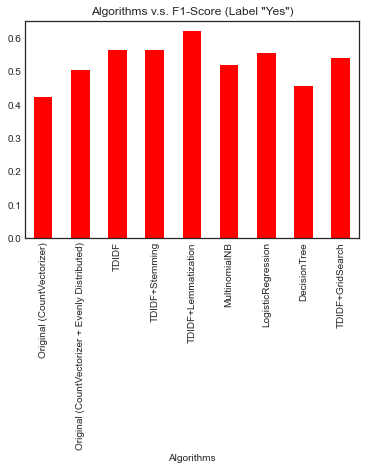

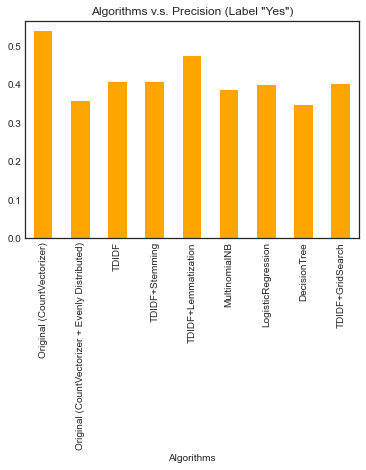

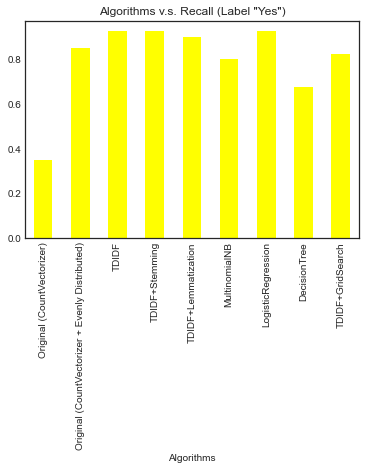

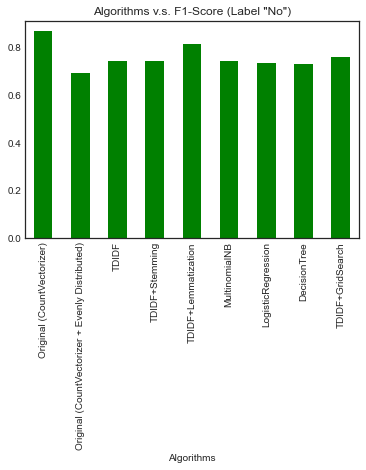

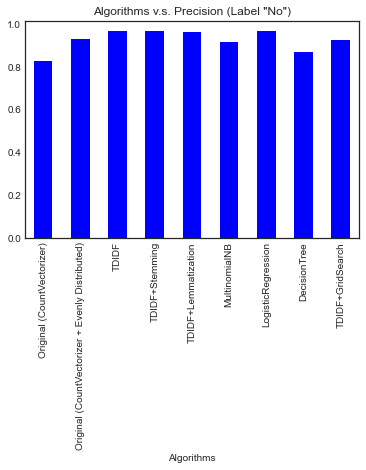

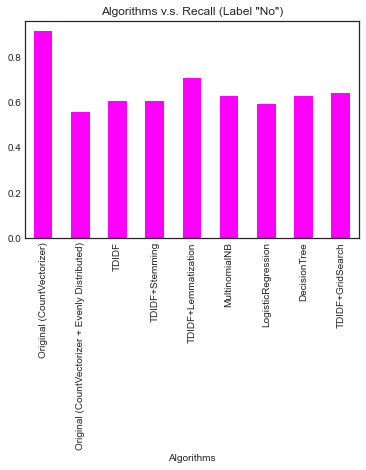

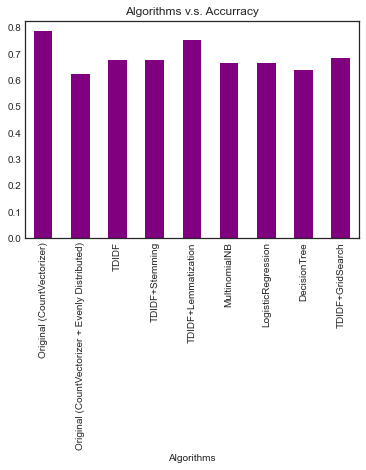

In [112]:
with pyplot.style.context('seaborn-white'):
    df.plot.bar(x='Algorithms', y='yes_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "Yes")', color='red', legend=False)
    df.plot.bar(x='Algorithms', y='yes_precision', rot=90, title='Algorithms v.s. Precision (Label "Yes")', color='orange', legend=False)
    df.plot.bar(x='Algorithms', y='yes_recall', rot=90, title='Algorithms v.s. Recall (Label "Yes")', color='yellow', legend=False)
    df.plot.bar(x='Algorithms', y='no_f1_score', rot=90, title='Algorithms v.s. F1-Score (Label "No")', color='green', legend=False)
    df.plot.bar(x='Algorithms', y='no_precision', rot=90, title='Algorithms v.s. Precision (Label "No")', color='blue', legend=False)
    df.plot.bar(x='Algorithms', y='no_recall', rot=90, title='Algorithms v.s. Recall (Label "No")', color='magenta', legend=False)
    df.plot.bar(x='Algorithms', y='Accuracy', rot=90, title='Algorithms v.s. Accurracy', color='purple', legend=False)

    # axes = df.plot.bar(rot=90, title="Algorithms Performance", subplots=True)

    pyplot.show(block=False)